# Notebook 1: Breast Cancer Classification using Gene Expression Data

## Environment Notes
This notebook was last tested on a `ml.t3.medium (2 vCPU + 4 GiB)` instance running the `Python 3 (Data Science)` kernel in SageMaker Studio.

## Table of Contents
1. [Background](#1.-Background)
2. [Data Preparation](#2.-Data-Preparation)
    1. [Download and Unzip Data](#2.A.-Download-and-Unzip-Data)
    2. [Load Normalized Gene Expression Data](#2.B.-Load-Normalized-Gene-Expression-Data)
    3. [Load Phenotype Data](#2.C.-Load-Phenotype-Data)
    4. [Merge the Normalized Gene Expression and Phenotype Data](#2.D.-Merge-the-Normalized-Gene-Expression-and-Phenotype-Data)
    5. [Encode Target Variable](#2.E.-Encode-Target-Variable)
    6. [Split the Data into Training-Validation-Test Sets](#2.F.-Split-the-Data-into-Training-Validation-Test-Sets)
3. [Model Training](#3.-Model-Training)
    1. [Train XGBoost Model](#3.A.-Train-XGBoost-Model)
    2. [Evaluate the Model Performance](#3.B.-Evaluate-the-Model-Performance)

## 1. Background

The increase in biological sequence data and development of sophisticated analysis techniques promises to dramatically improve healthcare. The "Central Dogma" of biology claims that the human body operates by transcribing DNA into messenger RNA, which is then translated into proteins. Each step in this process is managed by sequence information. So, the hope of bioinformatics is to decode these sequences and provide insight into their effect and possible alteration.

![alt text](img/640px-Gene_structure_eukaryote_2_annotated.png "Central Dogma")

*The structure and expression of a eukaryotic protein-coding gene. WikiJournal of Medicine 4 (1). DOI:10.15347/wjm/2017.002. ISSN 20024436. [(Wikimedia Commons)](https://commons.wikimedia.org/wiki/File:Gene_structure_eukaryote_2_annotated.svg)*

One of the more recent advances in sequence analysis is RNA sequencing (RNAseq). By using high-throughput sequencers, scientists can now capture a "snapshot" of what mRNA is present in a sample, and thus what genes are expressed, at any given time. RNAseq does not require prior knowledge of what genes to target and can capture alternatively-spliced variants which have been shown to have a significant impact on disease.

[A recent paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6097660/) from the Korkin lab at Worcester Polytechnic Institute explored several ways of performing "Tertiary Analysis" of RNAseq data using machine learning algorithms. The primary goal of this work was to determine if transcript-level information was more predictive of phenotypes than gene-level information (it was). However, the study is a good demonstration of the benefits and challenges of managing RNAseq-based ML experiments.

In this notebook, we'll demonstrate using RNAseq from the [Cancer Genome Atlas](https://www.nature.com/articles/nature11412) data to predict HER2 status, a binary classification task. Breast cancers with HER2-overexpression/amplification [(HER2+)](https://www.cancer.org/cancer/breast-cancer/understanding-a-breast-cancer-diagnosis/breast-cancer-her2-status.html) have a more aggressive natural history and are responsive to HER2-directed therapies.

## 2. Data Preparation

### 2.A. Download and Unzip Data

In this step, we download and extract two datasets from [The Cancer Genome Atlas](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga):

* [Normalized Gene Expression Data (1,218 samples)](https://xenabrowser.net/datapages/?dataset=TCGA.BRCA.sampleMap%2FHiSeqV2_PANCAN&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443): TCGA breast invasive carcinoma (BRCA) gene expression data measured experimentally using the IlluminaHiSeq RNAseq platform, mean-normalized (per gene) across all TCGA cohorts. Values in this dataset are generated at UCSC by combining gene expression RNAseq values of all TCGA cohorts. Values for each gene are then mean-centered per gene the data split back into cohorts.

* [Phenotypes (1,247 samples)](https://xenabrowser.net/datapages/?dataset=TCGA.BRCA.sampleMap%2FBRCA_clinicalMatrix&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443): TCGA breast invasive carcinoma (BRCA) clinically-observed phenotypes.

In [24]:
#!conda list
!pip install xgboost==1.2.0 #this needs this specific version of xgboost

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [25]:
import os
import argparse
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt 
import seaborn as sns

In [26]:
# Define working directories
WORKING_DIR = os.getcwd()
DATA_DIR = os.path.join(WORKING_DIR, "data")
print(f"Working directory is {WORKING_DIR}")
print(f"Data directory is {DATA_DIR}")

# Get TCGA BRCA Gene Expression Data
!wget https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz -nc -P $DATA_DIR/input/raw/
!gzip -df $DATA_DIR/input/raw/HiSeqV2_PANCAN.gz

# Get TCGA BRCA Phenotype Data
!wget https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix -nc -P $DATA_DIR/input/raw/

Working directory is /root/RNAseq_Tertiary_Analysis
Data directory is /root/RNAseq_Tertiary_Analysis/data
--2022-01-18 16:05:57--  https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz
Resolving tcga.xenahubs.net (tcga.xenahubs.net)... 3.85.156.153, 35.168.172.110, 52.2.123.35, ...
Connecting to tcga.xenahubs.net (tcga.xenahubs.net)|3.85.156.153|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://tcga-xena-hub.s3.us-east-1.amazonaws.com:443/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz [following]
--2022-01-18 16:05:57--  https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz
Resolving tcga-xena-hub.s3.us-east-1.amazonaws.com (tcga-xena-hub.s3.us-east-1.amazonaws.com)... 54.231.192.90
Connecting to tcga-xena-hub.s3.us-east-1.amazonaws.com (tcga-xena-hub.s3.us-east-1.amazonaws.com)|54.231.192.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83389754 (80

### 2.B. Load Normalized Gene Expression Data

In [27]:
# Read in RNAseq data file
genom = pd.read_csv(f"{DATA_DIR}/input/raw/HiSeqV2_PANCAN", sep='\t')
print(f"The gene expression data has {genom.shape[0]} records and {genom.shape[1]} columns\n")

# Extract list of sample identifiers
genom_identifiers = genom["sample"].values.tolist()

# Print the first few records
print("Example gene expression data:")
genom.head(3)

The gene expression data has 20530 records and 1219 columns

Example gene expression data:


,sample,TCGA-AR-A5QQ-01,TCGA-D8-A1JA-01,TCGA-BH-A0BQ-01,TCGA-BH-A0BT-01,TCGA-A8-A06X-01,TCGA-A8-A096-01,TCGA-BH-A0C7-01,TCGA-AC-A5XU-01,TCGA-PE-A5DE-01,...,TCGA-A7-A13E-11,TCGA-C8-A8HP-01,TCGA-E9-A5FL-01,TCGA-AC-A2FB-11,TCGA-E2-A15F-01,TCGA-A2-A3XT-01,TCGA-B6-A0X7-01,TCGA-BH-A1EV-11,TCGA-3C-AALJ-01,TCGA-B6-A0X1-01
0,ARHGEF10L,-0.356592,-2.429392,-0.542392,-0.844192,-0.222292,-0.097492,0.229108,-0.711592,0.075808,...,-0.237492,0.318608,0.055908,0.045008,0.169408,1.650408,0.710508,-0.459192,1.082808,0.452408
1,HIF3A,-3.976026,-1.894026,-2.832326,-4.213326,-4.972826,-5.280926,-1.945726,-5.080926,-2.616926,...,2.599874,-3.338826,-1.690226,2.632474,-4.671126,-4.237826,-1.485126,1.698974,-4.623726,-3.135626
2,RNF17,-0.531035,0.093465,0.021565,-0.531035,-0.531035,0.345465,-0.531035,-0.531035,-0.531035,...,-0.531035,-0.531035,3.199465,-0.531035,-0.531035,0.601865,-0.105235,-0.531035,-0.531035,-0.531035


### 2.C. Load Phenotype Data

In [28]:
phenotypes = pd.read_csv(f"{DATA_DIR}/input/raw/BRCA_clinicalMatrix", sep='\t')
print(f"The phenotype data has {phenotypes.shape[0]} records and {phenotypes.shape[1]} columns.\n")

# Print the first few records
print("Example phenotype data:")
phenotypes.loc[[0,100,200,300,400,500]]

The phenotype data has 1247 records and 194 columns.

Example phenotype data:


,sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,NaN,TCGA-3C-AAAU-01A-11D-A41E-01,TCGA-3C-AAAU-01,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,TCGA-3C-AAAU-01A-11D-A41E-01,NaN
100,TCGA-A2-A25A-01,Stage IIA,44.0,2.0,Stage IIA,2968.0,NaN,Positive,FEMALE,Negative,...,TCGA-A2-A25A-01A-12D-A16D-09,NaN,50c720f4-dbcb-4b8b-9808-d130f5197d27,NaN,TCGA-A2-A25A-01A-12D-A16C-01,TCGA-A2-A25A-01,NaN,50c720f4-dbcb-4b8b-9808-d130f5197d27,TCGA-A2-A25A-01A-12D-A16C-01,NaN
200,TCGA-A8-A07P-01,Stage IIB,68.0,4.0,Stage IIB,334.0,NaN,Positive,FEMALE,Positive,...,TCGA-A8-A07P-01A-11W-A019-09,TCGA-A8-A07P-01,dad4f72e-cb2c-4015-af6a-53ad0ae45f12,TCGA-A8-A07P-01,TCGA-A8-A07P-01A-11D-A011-01,NaN,TCGA-A8-A07P-01A-11R-A00Z-07,dad4f72e-cb2c-4015-af6a-53ad0ae45f12,TCGA-A8-A07P-01A-11D-A011-01,TCGA-A8-A07P-01
300,TCGA-AC-A5XS-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,b713b36d-44c7-41ed-82a5-762322472a56,NaN,TCGA-AC-A5XS-01A-11D-A29M-01,TCGA-AC-A5XS-01,NaN,b713b36d-44c7-41ed-82a5-762322472a56,TCGA-AC-A5XS-01A-11D-A29M-01,NaN
400,TCGA-AO-A1KQ-01,Stage IIIB,84.0,4.0,Stage IIIB,1519.0,NaN,Positive,MALE,Negative,...,NaN,NaN,204a78d9-67aa-4e49-b285-bbb25c6ed142,NaN,TCGA-AO-A1KQ-01A-11D-A13J-01,TCGA-AO-A1KQ-01,NaN,204a78d9-67aa-4e49-b285-bbb25c6ed142,TCGA-AO-A1KQ-01A-11D-A13J-01,NaN
500,TCGA-B6-A0IP-01,Stage IA,74.0,2.0,Stage I,3374.0,NaN,Positive,FEMALE,Negative,...,TCGA-B6-A0IP-01A-11D-A045-09,TCGA-B6-A0IP-01,9384eb09-5787-49e8-b07e-bd9f71997771,TCGA-B6-A0IP-01,TCGA-B6-A0IP-01A-11D-A036-01,NaN,TCGA-B6-A0IP-01A-11R-A034-07,9384eb09-5787-49e8-b07e-bd9f71997771,TCGA-B6-A0IP-01A-11D-A036-01,TCGA-B6-A0IP-01


There are a lot of potential phenotypic values to choose as targets. For this example, let's focus our attention on `HER2_Final_Status_nature2012`.

In [29]:
phenotypes_subset = phenotypes[["sampleID", "HER2_Final_Status_nature2012"]].reset_index(drop=True)

Let's replace any missing HER2 values with `Negative`

In [30]:
print(f"Of the {phenotypes_subset.shape[0]} records, only {phenotypes_subset.dropna().shape[0]} have complete HER2 values. Let's replace the missing values with 'Negative'.\n")

phenotypes_subset.fillna("Negative", inplace=True)
print("Example phenotype data:")
phenotypes_subset.head(10)

Of the 1247 records, only 776 have complete HER2 values. Let's replace the missing values with 'Negative'.

Example phenotype data:


,sampleID,HER2_Final_Status_nature2012
0,TCGA-3C-AAAU-01,Negative
1,TCGA-3C-AALI-01,Negative
2,TCGA-3C-AALJ-01,Negative
3,TCGA-3C-AALK-01,Negative
4,TCGA-4H-AAAK-01,Negative
5,TCGA-5L-AAT0-01,Negative
6,TCGA-5L-AAT1-01,Negative
7,TCGA-5T-A9QA-01,Negative
8,TCGA-A1-A0SB-01,Negative
9,TCGA-A1-A0SD-01,Negative


### 2.D. Merge the Normalized Gene Expression and Phenotype Data

The gene expression and phenotype data are oriented in different directions, so let's transpose the former before we merge them together.

In [31]:
genom_transpose = genom.set_index("sample").transpose().reset_index().rename(columns={"index": "sampleID"})
print(f"Transposing the gene expression data changes its shape from {genom.shape[0]} x {genom.shape[1]} to {genom_transpose.shape[0]} x {genom_transpose.shape[1]}.\n")

print("Example transposed gene expression data:")
genom_transpose.loc[[0,100,200,300,400,500]]

Transposing the gene expression data changes its shape from 20530 x 1219 to 1218 x 20531.

Example transposed gene expression data:


sample,sampleID,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,TCGA-AR-A5QQ-01,-0.356592,-3.976026,-0.531035,-0.409972,0.161322,-0.51811,-0.896294,-1.023046,-0.423399,...,-0.166978,-1.587117,0.856067,-0.69949,-0.034577,1.987914,-0.081627,0.297105,2.320067,0.617988
100,TCGA-A2-A0D4-01,1.071308,-1.538926,-0.531035,0.366128,-0.856178,-0.30451,-0.217594,1.243954,0.192501,...,-0.748878,0.059083,-1.488733,-1.28139,-0.834177,-0.240986,1.139673,-0.092095,-1.081433,0.167288
200,TCGA-A8-A08P-01,-0.253192,-4.171526,-0.531035,0.018128,-0.482378,0.96379,-0.112694,-0.511546,0.959801,...,-0.748878,-1.587117,1.182367,0.10181,0.483023,-0.010586,0.786073,-0.572595,-0.340333,0.346788
300,TCGA-AN-A0FX-01,0.340508,0.649374,1.740365,-0.388972,-0.386578,0.19859,0.026606,-0.100246,-0.423399,...,-0.036978,3.636483,-0.564333,-1.28139,0.563523,1.516114,0.771273,0.301605,1.021467,-0.986612
400,TCGA-BH-A0DH-11,-0.443392,2.092074,-0.531035,0.052328,-0.161978,-0.09801,0.484006,2.215654,-0.423399,...,0.130522,3.781083,0.304067,-0.10549,0.312723,2.948214,1.657573,0.609705,3.814167,-0.204312
500,TCGA-BH-A0HF-01,-0.465192,-1.948126,-0.531035,0.054428,0.385322,0.35809,-0.158694,0.512854,-0.423399,...,-0.748878,2.391083,0.519067,0.59971,-0.372477,1.128214,1.544773,0.265605,3.237367,0.278288


Merge the phenotype data with the transposed gene expression data on `sampleID`

In [32]:
df = pd.merge(phenotypes_subset, genom_transpose, on="sampleID", how="outer")
print(f"The merged data set has {df.shape[0]} records and {df.shape[1]} columns.\n")

The merged data set has 1247 records and 20532 columns.



Let's look at the results for 6 specific samples.

In [33]:
df.loc[[0,100,200,300,400,500]]

,sampleID,HER2_Final_Status_nature2012,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,TCGA-3C-AAAU-01,Negative,0.607308,-3.194126,-0.531035,-0.145872,0.237422,-0.29921,-0.142694,-0.217446,...,-0.748878,0.565583,-0.767233,-1.28139,-0.271377,-0.492286,0.360373,1.067905,0.076267,-0.392212
100,TCGA-A2-A25A-01,Negative,-0.109892,-0.079726,-0.531035,0.105228,0.586722,0.21839,-0.145994,1.731154,...,0.181522,6.125683,0.576567,-1.28139,0.292723,1.339014,2.594573,-0.261095,4.387167,-0.410412
200,TCGA-A8-A07P-01,Positive,-0.826392,-4.528526,-0.531035,0.107628,0.959022,0.89679,-0.122094,-0.307246,...,0.277322,-1.159017,-0.127633,-1.28139,-0.828377,-0.147486,0.273573,-0.423495,0.525567,0.659688
300,TCGA-AC-A5XS-01,Negative,-0.539492,-2.258026,-0.531035,0.204328,0.217822,-0.10851,-0.308394,0.062654,...,-0.748878,-1.036717,0.422667,0.23371,-1.242977,0.611014,1.230373,0.490305,2.490267,0.780188
400,TCGA-AO-A1KQ-01,Negative,-0.758592,-4.253926,-0.531035,0.079928,-0.135978,-0.13821,0.167806,0.318054,...,-0.175578,3.133683,0.397967,-0.29899,0.775423,-0.184586,-0.285527,0.371905,-0.202533,0.864788
500,TCGA-B6-A0IP-01,Negative,0.716208,-3.858326,0.110665,0.566228,0.429122,-0.30791,0.490806,-0.154446,...,0.131022,2.346983,-0.540533,-1.28139,-0.022677,0.020714,0.318873,0.427305,2.008267,-0.012512


### 2.E. Encode Target Variable

In [34]:
df["target"] = [0 if t == "Negative" else 1 for t in df['HER2_Final_Status_nature2012']]
df.insert(loc=1, column='target', value=df.pop('target'))
df.loc[[0,100,200,300,400,500]]

,sampleID,target,HER2_Final_Status_nature2012,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,TCGA-3C-AAAU-01,0,Negative,0.607308,-3.194126,-0.531035,-0.145872,0.237422,-0.29921,-0.142694,...,-0.748878,0.565583,-0.767233,-1.28139,-0.271377,-0.492286,0.360373,1.067905,0.076267,-0.392212
100,TCGA-A2-A25A-01,0,Negative,-0.109892,-0.079726,-0.531035,0.105228,0.586722,0.21839,-0.145994,...,0.181522,6.125683,0.576567,-1.28139,0.292723,1.339014,2.594573,-0.261095,4.387167,-0.410412
200,TCGA-A8-A07P-01,1,Positive,-0.826392,-4.528526,-0.531035,0.107628,0.959022,0.89679,-0.122094,...,0.277322,-1.159017,-0.127633,-1.28139,-0.828377,-0.147486,0.273573,-0.423495,0.525567,0.659688
300,TCGA-AC-A5XS-01,0,Negative,-0.539492,-2.258026,-0.531035,0.204328,0.217822,-0.10851,-0.308394,...,-0.748878,-1.036717,0.422667,0.23371,-1.242977,0.611014,1.230373,0.490305,2.490267,0.780188
400,TCGA-AO-A1KQ-01,0,Negative,-0.758592,-4.253926,-0.531035,0.079928,-0.135978,-0.13821,0.167806,...,-0.175578,3.133683,0.397967,-0.29899,0.775423,-0.184586,-0.285527,0.371905,-0.202533,0.864788
500,TCGA-B6-A0IP-01,0,Negative,0.716208,-3.858326,0.110665,0.566228,0.429122,-0.30791,0.490806,...,0.131022,2.346983,-0.540533,-1.28139,-0.022677,0.020714,0.318873,0.427305,2.008267,-0.012512


We'll drop any rows with `NaN` values

In [35]:
df = df.dropna()

What's the distribution between our positive and negative classes?

In [36]:
print("How many of the samples are positive for HER2?")
print(df.target.value_counts())

How many of the samples are positive for HER2?
0    1094
1     124
Name: target, dtype: int64


Since only 10% of the samples are positive, we may want to weight our classes differently during training

Here are the `target` values for our six samples of interest.

In [37]:
df.loc[[0,100,200,300,400,500],['sampleID','HER2_Final_Status_nature2012','target']]

,sampleID,HER2_Final_Status_nature2012,target
0,TCGA-3C-AAAU-01,Negative,0
100,TCGA-A2-A25A-01,Negative,0
200,TCGA-A8-A07P-01,Positive,1
300,TCGA-AC-A5XS-01,Negative,0
400,TCGA-AO-A1KQ-01,Negative,0
500,TCGA-B6-A0IP-01,Negative,0


Let's remove the original target value and sampleID to prevent data leakage

In [38]:
df = df.drop(['HER2_Final_Status_nature2012','sampleID'], axis=1)

Finally, let's review the transformed data for our six samples of interest.

In [39]:
df.loc[[0,100,200,300,400,500]]

,target,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,0,0.607308,-3.194126,-0.531035,-0.145872,0.237422,-0.29921,-0.142694,-0.217446,0.333001,...,-0.748878,0.565583,-0.767233,-1.28139,-0.271377,-0.492286,0.360373,1.067905,0.076267,-0.392212
100,0,-0.109892,-0.079726,-0.531035,0.105228,0.586722,0.21839,-0.145994,1.731154,-0.128999,...,0.181522,6.125683,0.576567,-1.28139,0.292723,1.339014,2.594573,-0.261095,4.387167,-0.410412
200,1,-0.826392,-4.528526,-0.531035,0.107628,0.959022,0.89679,-0.122094,-0.307246,-0.423399,...,0.277322,-1.159017,-0.127633,-1.28139,-0.828377,-0.147486,0.273573,-0.423495,0.525567,0.659688
300,0,-0.539492,-2.258026,-0.531035,0.204328,0.217822,-0.10851,-0.308394,0.062654,-0.423399,...,-0.748878,-1.036717,0.422667,0.23371,-1.242977,0.611014,1.230373,0.490305,2.490267,0.780188
400,0,-0.758592,-4.253926,-0.531035,0.079928,-0.135978,-0.13821,0.167806,0.318054,0.149901,...,-0.175578,3.133683,0.397967,-0.29899,0.775423,-0.184586,-0.285527,0.371905,-0.202533,0.864788
500,0,0.716208,-3.858326,0.110665,0.566228,0.429122,-0.30791,0.490806,-0.154446,-0.423399,...,0.131022,2.346983,-0.540533,-1.28139,-0.022677,0.020714,0.318873,0.427305,2.008267,-0.012512


### 2.F. Split the Data into Training-Validation-Test Sets

In [40]:
# Hold out 20% of the data for testing
train_df, test_df = train_test_split(df, test_size=0.2)

# Hold out an additional 20% of the training data for validaton
train_df, val_df = train_test_split(train_df, test_size=0.2)

print(f"The training data has {train_df.shape[0]} records and {train_df.shape[1]} columns.")
print(f"The validation data has {val_df.shape[0]} records and {val_df.shape[1]} columns.")
print(f"The test data has {test_df.shape[0]} records and {test_df.shape[1]} columns.")

The training data has 779 records and 20531 columns.
The validation data has 195 records and 20531 columns.
The test data has 244 records and 20531 columns.


Convert labels and features into numpy arrays

In [41]:
train_labels = np.array(train_df.pop("target"))
val_labels = np.array(val_df.pop("target"))
test_labels = np.array(test_df.pop("target"))

train_np = np.array(train_df)
val_np = np.array(val_df)
test_np = np.array(test_df)

## 3. Model Training

### 3.A. Train XGBoost Model

In [42]:
hyper_params_dict = {
    'objective':             "binary:logistic",
    'booster':               "gbtree",
    'eval_metric':           "error",
    'n_estimators':          15,
    'max_depth':             3, 
    'min_child_weight':      5,
    'subsample':             0.9,
    'gamma':                 0.01
}
    
# Use the scale_pos_weight parameter to account for the imbalanced classes in our data
pos_weight = float(np.sum(train_labels == 0) / np.sum(train_labels == 1))
    
breast_cancer_classifier = xgb.XGBClassifier(
    **hyper_params_dict, 
    use_label_encoder=False, 
    scale_pos_weight=pos_weight # Use pos_weight value calculated above to account for unbalanced classes
)

breast_cancer_classifier.fit(
    train_np,
    train_labels,
    eval_set=[(train_np, train_labels), (val_np, val_labels)], 
    verbose=True
)

[16:06:27] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.07959	validation_1-error:0.12821
[1]	validation_0-error:0.02952	validation_1-error:0.07179
[2]	validation_0-error:0.02824	validation_1-error:0.06667
[3]	validation_0-error:0.02439	validation_1-error:0.06154
[4]	validation_0-error:0.01797	validation_1-error:0.05641
[5]	validation_0-error:0.01284	validation_1-error:0.05128
[6]	validation_0-error:0.01027	validation_1-error:0.05128
[7]	validation_0-error:0.00899	validation_1-error:0.05128
[8]	validation_0-error:0.00899	validation_1-error:0.04615
[9]	validation_0-error:0.00770	validation_1-error:0.04615
[10]	validation_0-error:0.00513	validation_1-error:0.04615
[11]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0.01, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=15, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8.7375, subsample=0.9,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### 3.B. Evaluate the Model Performance

Plot learning curves

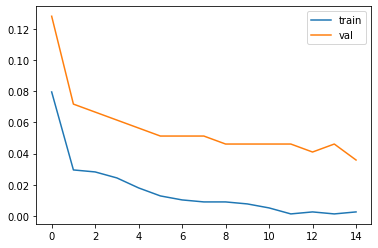

In [43]:
results = breast_cancer_classifier.evals_result()
plt.plot(results['validation_0']['error'], label='train')
plt.plot(results['validation_1']['error'], label='val')
plt.legend()
plt.show()

Evaluate model accuracy on test data

In [44]:
# Create a custom function for generating a confusion matrix for a given p-value
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    if len(set(list(labels))) == 2:
        print('Correctly un-detected (True Negatives): ', cm[0][0])
        print('Incorrectly detected (False Positives): ', cm[0][1])
        print('Misses (False Negatives): ', cm[1][0])
        print('Hits (True Positives): ', cm[1][1])
        print('Total: ', np.sum(cm[1]))

Correctly un-detected (True Negatives):  205
Incorrectly detected (False Positives):  8
Misses (False Negatives):  5
Hits (True Positives):  26
Total:  31
Accuracy: 0.95
Precision: 0.76
F1 Score: 0.80


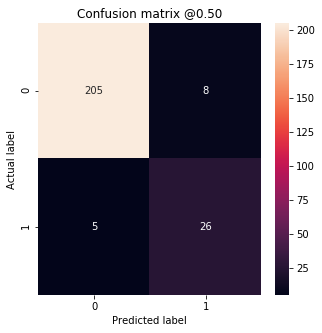

In [45]:
# evaluate predictions
test_predictions = breast_cancer_classifier.predict(test_np)
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

plot_cm(test_labels, np.array(test_predictions))

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")